In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\sachur\AppData\Local\Temp\ipykernel_400\2515328079.py:105: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


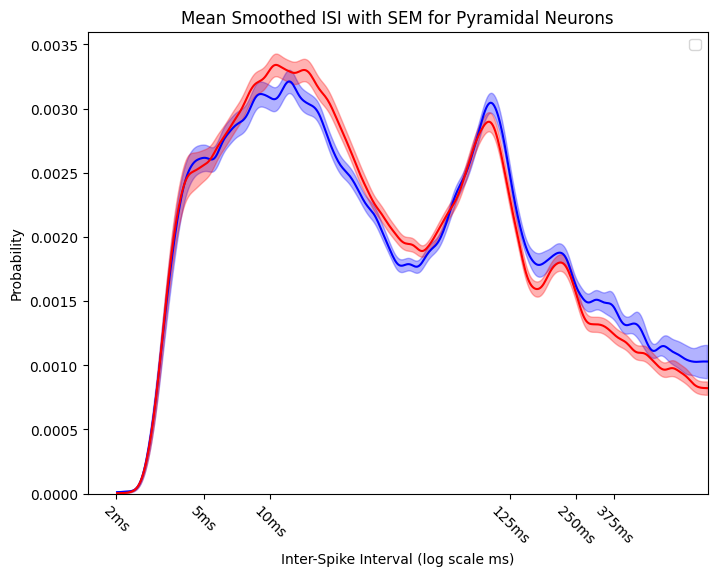

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_py = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp-/- and Pde1c -/-')& (df_good['sub_population']=='deep')]

# Parameters from the MATLAB function
min_isi_param = 0.002  # bin width for linear or min for log
max_isi_param = 1
smooth_isi = 5
log = True  # Set to True to match the previous log-scaled task

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

# Collect smoothed histograms for all neurons
isihist_sm_list = []
for t in df_py['spike_times']:
    # Compute inter-spike intervals (ISI)
    isi = np.diff(t)
    isi = isi[isi > 0]
    if len(isi) == 0:
        continue

    # Compute histogram with 'probability' normalization
    counts, _ = np.histogram(isi, bins=edges)
    isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
    #isihist = counts
    # Smooth the histogram
    isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
    isihist_sm_list.append(isihist_sm)

# Convert to array for mean and SEM calculation
isihist_sm_array = np.array(isihist_sm_list)
mean_isihist = np.mean(isihist_sm_array, axis=0)
sem_isihist = np.std(isihist_sm_array, axis=0) / np.sqrt(len(isihist_sm_array))
#sem_isihist = np.std(isihist_sm_array, axis=0)
# Plot mean curve with SEM shaded area
plt.figure(figsize=(8, 6))
plt.plot(time, mean_isihist, color='blue')
plt.fill_between(time, mean_isihist - sem_isihist, mean_isihist + sem_isihist, 
                 color='blue', alpha=0.3)

if log:
    plt.xscale('log')
    tick_positions = [0.002, 0.005, 0.01, .125, .25, .375]
    tick_labels = ['2ms','5ms','10ms', '125ms', '250ms', '375ms']
    plt.minorticks_off()


df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_py = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-') & (df_good['sub_population']=='deep')]


# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

# Collect smoothed histograms for all neurons
isihist_sm_list = []
for t in df_py['spike_times']:
    # Compute inter-spike intervals (ISI)
    isi = np.diff(t)
    isi = isi[isi > 0]
    if len(isi) == 0:
        continue

    # Compute histogram with 'probability' normalization
    counts, _ = np.histogram(isi, bins=edges)
    isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
    #isihist = counts
    # Smooth the histogram
    isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
    isihist_sm_list.append(isihist_sm)

# Convert to array for mean and SEM calculation
isihist_sm_array = np.array(isihist_sm_list)
mean_isihist = np.mean(isihist_sm_array, axis=0)
sem_isihist = np.std(isihist_sm_array, axis=0) / np.sqrt(len(isihist_sm_array))
#sem_isihist = np.std(isihist_sm_array, axis=0)

# Plot mean curve with SEM shaded area
plt.plot(time, mean_isihist, color='red')
plt.fill_between(time, mean_isihist - sem_isihist, mean_isihist + sem_isihist, 
                 color='red', alpha=0.3)


plt.xticks(tick_positions, tick_labels, rotation=-45)
plt.xlabel('Inter-Spike Interval (log scale ms)' if log else 'Inter-Spike Interval')
plt.ylabel('Probability')
plt.title('Mean Smoothed ISI with SEM for Pyramidal Neurons')
plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.legend()
plt.show()

C:\Users\sachur\AppData\Local\Temp\ipykernel_400\3806592988.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


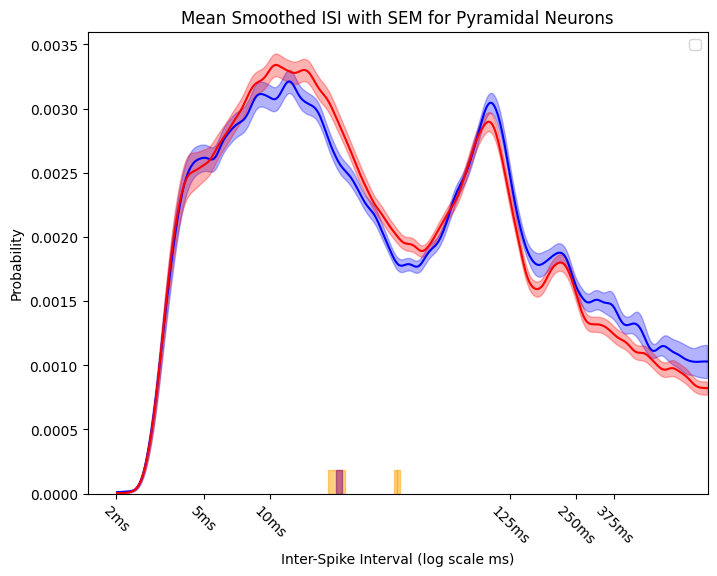

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_ko = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp-/- and Pde1c -/-')& (df_good['sub_population']=='deep')]
df_het = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-') & (df_good['sub_population']=='deep')]

# Parameters from the MATLAB function
min_isi_param = 0.002  # bin width for linear or min for log
max_isi_param = 1
smooth_isi = 5
log = True  # Set to True to match the previous log-scaled task

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

def get_isihist_sm(df):
    isihist_sm_list = []
    for t in df['spike_times']:
        # Compute inter-spike intervals (ISI)
        isi = np.diff(t)
        isi = isi[isi > 0]
        if len(isi) == 0:
            continue

        # Compute histogram with 'probability' normalization
        counts, _ = np.histogram(isi, bins=edges)
        isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
        # Smooth the histogram
        isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
        isihist_sm_list.append(isihist_sm)
    return np.array(isihist_sm_list)

isihist_sm_ko = get_isihist_sm(df_ko)
isihist_sm_het = get_isihist_sm(df_het)

mean_ko = np.mean(isihist_sm_ko, axis=0)
sem_ko = np.std(isihist_sm_ko, axis=0) / np.sqrt(isihist_sm_ko.shape[0])

mean_het = np.mean(isihist_sm_het, axis=0)
sem_het = np.std(isihist_sm_het, axis=0) / np.sqrt(isihist_sm_het.shape[0])

# Plot mean curve with SEM shaded area
plt.figure(figsize=(8, 6))
plt.plot(time, mean_ko, color='blue')
plt.fill_between(time, mean_ko - sem_ko, mean_ko + sem_ko, 
                 color='blue', alpha=0.3)
plt.plot(time, mean_het, color='red')
plt.fill_between(time, mean_het - sem_het, mean_het + sem_het, 
                 color='red', alpha=0.3)

if log:
    plt.xscale('log')
    tick_positions = [0.002, 0.005, 0.01, .125, .25, .375]
    tick_labels = ['2ms','5ms','10ms', '125ms', '250ms', '375ms']
    plt.minorticks_off()
    plt.xticks(tick_positions, tick_labels, rotation=-45)

plt.xlabel('Inter-Spike Interval (log scale ms)' if log else 'Inter-Spike Interval')
plt.ylabel('Probability')
plt.title('Mean Smoothed ISI with SEM for Pyramidal Neurons')
plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
plt.ylim(bottom=0)  # Ensure y-axis starts at 0

# Statistical assessment using permutation test
alpha = 0.01
M = 1000  # Number of permutations
n_ko = isihist_sm_ko.shape[0]
n_het = isihist_sm_het.shape[0]
all_hist = np.vstack((isihist_sm_ko, isihist_sm_het))
D0 = mean_ko - mean_het

rng = np.random.RandomState(42)
D_perms = np.zeros((M, len(time)))
for m in range(M):
    idx = rng.permutation(n_ko + n_het)
    perm_ko = all_hist[idx[:n_ko]]
    perm_het = all_hist[idx[n_ko:]]
    D_perms[m] = np.mean(perm_ko, 0) - np.mean(perm_het, 0)

# Pointwise bands
p_l = alpha / 2 * 100
p_u = 100 - (alpha / 2 * 100)
f_minus = np.percentile(D_perms, p_l, axis=0)
f_plus = np.percentile(D_perms, p_u, axis=0)
pointwise_sig = (D0 > f_plus) | (D0 < f_minus)

# Global bands - binary search for the largest gamma where accepted prop >= 1 - alpha
def compute_prop(gamma):
    p_l = gamma / 2 * 100
    p_u = 100 - (gamma / 2 * 100)
    g_minus = np.percentile(D_perms, p_l, axis=0)
    g_plus = np.percentile(D_perms, p_u, axis=0)
    inside = (D_perms >= g_minus) & (D_perms <= g_plus)
    num_inside = np.sum(np.all(inside, axis=1))
    prop = num_inside / M
    return prop

low = 1e-5
high = 0.5
tol = 1e-4
while high - low > tol:
    mid = (low + high) / 2
    prop = compute_prop(mid)
    if prop >= 1 - alpha:
        low = mid
    else:
        high = mid
gamma_global = low

# Compute global bands
p_l = gamma_global / 2 * 100
p_u = 100 - (gamma_global / 2 * 100)
g_minus = np.percentile(D_perms, p_l, axis=0)
g_plus = np.percentile(D_perms, p_u, axis=0)
global_sig = (D0 > g_plus) | (D0 < g_minus)

# Plot significance regions (axvspan for segments)
y_min, y_max = plt.ylim()
sig_ymax = 0.05 * y_max

# Pointwise segments in orange
pointwise_sig = pointwise_sig.astype(int)
diff_p = np.diff(np.pad(pointwise_sig, (1, 1), 'constant'))
starts_p = np.where(diff_p == 1)[0] - 1
ends_p = np.where(diff_p == -1)[0] - 1
for s, e in zip(starts_p, ends_p):
    x_start = edges[s]
    x_end = edges[e + 1]
    plt.axvspan(x_start, x_end, ymin=0, ymax=sig_ymax / y_max, color='orange', alpha=0.5)

# Global segments in purple
global_sig = global_sig.astype(int)
diff_g = np.diff(np.pad(global_sig, (1, 1), 'constant'))
starts_g = np.where(diff_g == 1)[0] - 1
ends_g = np.where(diff_g == -1)[0] - 1
for s, e in zip(starts_g, ends_g):
    x_start = edges[s]
    x_end = edges[e + 1]
    plt.axvspan(x_start, x_end, ymin=0, ymax=sig_ymax / y_max, color='purple', alpha=0.5)

plt.legend()
plt.show()

C:\Users\sachur\AppData\Local\Temp\ipykernel_400\2052517156.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


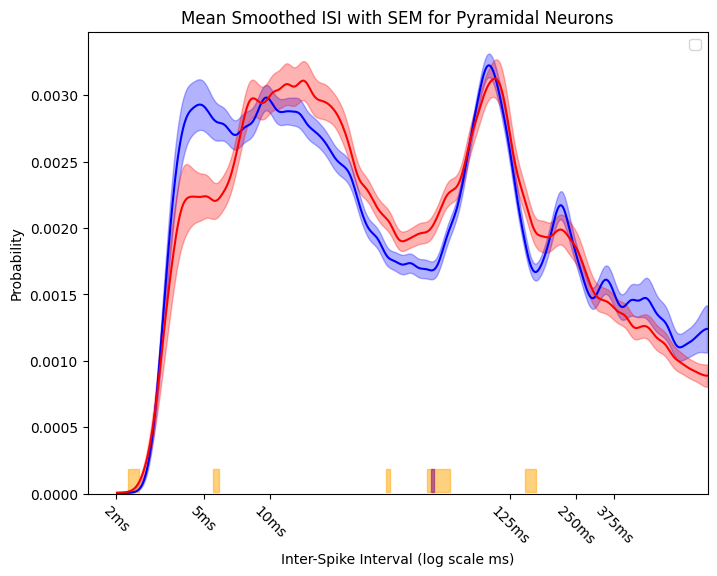

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

df_good = pd.read_pickle(r'q:\sachuriga\CR_CA1_paper\tables\functional_properties_with_python_measurements_pycirc.pkl')
df_ko = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp-/- and Pde1c -/-')& (df_good['sub_population']=='superficial')]
df_het = df_good[(df_good['buzaki_py_cell_type']=='pyramidal') & (df_good['session'] == 'A') & (df_good['genotype']=='NDNF-flp +/- and Pde1c +/-') & (df_good['sub_population']=='superficial')]

# Parameters from the MATLAB function
min_isi_param = 0.002  # bin width for linear or min for log
max_isi_param = 1
smooth_isi = 5
log = True  # Set to True to match the previous log-scaled task

# Compute common bin edges
if log:
    num_bins = int(max_isi_param / min_isi_param)
    edges = np.logspace(np.log10(min_isi_param), np.log10(max_isi_param), num_bins + 1)
else:
    edges = np.arange(0, max_isi_param + min_isi_param, min_isi_param)

time = (edges[:-1] + edges[1:]) / 2

def get_isihist_sm(df):
    isihist_sm_list = []
    for t in df['spike_times']:
        # Compute inter-spike intervals (ISI)
        isi = np.diff(t)
        isi = isi[isi > 0]
        if len(isi) == 0:
            continue

        # Compute histogram with 'probability' normalization
        counts, _ = np.histogram(isi, bins=edges)
        isihist = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(time)
        # Smooth the histogram
        isihist_sm = gaussian_filter1d(isihist, sigma=smooth_isi)
        isihist_sm_list.append(isihist_sm)
    return np.array(isihist_sm_list)

isihist_sm_ko = get_isihist_sm(df_ko)
isihist_sm_het = get_isihist_sm(df_het)

mean_ko = np.mean(isihist_sm_ko, axis=0)
sem_ko = np.std(isihist_sm_ko, axis=0) / np.sqrt(isihist_sm_ko.shape[0])

mean_het = np.mean(isihist_sm_het, axis=0)
sem_het = np.std(isihist_sm_het, axis=0) / np.sqrt(isihist_sm_het.shape[0])

# Plot mean curve with SEM shaded area
plt.figure(figsize=(8, 6))
plt.plot(time, mean_ko, color='blue')
plt.fill_between(time, mean_ko - sem_ko, mean_ko + sem_ko, 
                 color='blue', alpha=0.3)
plt.plot(time, mean_het, color='red')
plt.fill_between(time, mean_het - sem_het, mean_het + sem_het, 
                 color='red', alpha=0.3)

if log:
    plt.xscale('log')
    tick_positions = [0.002, 0.005, 0.01, .125, .25, .375]
    tick_labels = ['2ms','5ms','10ms', '125ms', '250ms', '375ms']
    plt.minorticks_off()
    plt.xticks(tick_positions, tick_labels, rotation=-45)

plt.xlabel('Inter-Spike Interval (log scale ms)' if log else 'Inter-Spike Interval')
plt.ylabel('Probability')
plt.title('Mean Smoothed ISI with SEM for Pyramidal Neurons')
plt.xlim(0, max_isi_param)  # Set x-axis to start at 0
plt.ylim(bottom=0)  # Ensure y-axis starts at 0

# Statistical assessment using permutation test
alpha = 0.01
M = 1000  # Number of permutations
n_ko = isihist_sm_ko.shape[0]
n_het = isihist_sm_het.shape[0]
all_hist = np.vstack((isihist_sm_ko, isihist_sm_het))
D0 = mean_ko - mean_het

rng = np.random.RandomState(42)
D_perms = np.zeros((M, len(time)))
for m in range(M):
    idx = rng.permutation(n_ko + n_het)
    perm_ko = all_hist[idx[:n_ko]]
    perm_het = all_hist[idx[n_ko:]]
    D_perms[m] = np.mean(perm_ko, 0) - np.mean(perm_het, 0)

# Pointwise bands
p_l = alpha / 2 * 100
p_u = 100 - (alpha / 2 * 100)
f_minus = np.percentile(D_perms, p_l, axis=0)
f_plus = np.percentile(D_perms, p_u, axis=0)
pointwise_sig = (D0 > f_plus) | (D0 < f_minus)

# Global bands - binary search for the largest gamma where accepted prop >= 1 - alpha
def compute_prop(gamma):
    p_l = gamma / 2 * 100
    p_u = 100 - (gamma / 2 * 100)
    g_minus = np.percentile(D_perms, p_l, axis=0)
    g_plus = np.percentile(D_perms, p_u, axis=0)
    inside = (D_perms >= g_minus) & (D_perms <= g_plus)
    num_inside = np.sum(np.all(inside, axis=1))
    prop = num_inside / M
    return prop

low = 1e-5
high = 0.5
tol = 1e-4
while high - low > tol:
    mid = (low + high) / 2
    prop = compute_prop(mid)
    if prop >= 1 - alpha:
        low = mid
    else:
        high = mid
gamma_global = low

# Compute global bands
p_l = gamma_global / 2 * 100
p_u = 100 - (gamma_global / 2 * 100)
g_minus = np.percentile(D_perms, p_l, axis=0)
g_plus = np.percentile(D_perms, p_u, axis=0)
global_sig = (D0 > g_plus) | (D0 < g_minus)

# Plot significance regions (axvspan for segments)
y_min, y_max = plt.ylim()
sig_ymax = 0.05 * y_max

# Pointwise segments in orange
pointwise_sig = pointwise_sig.astype(int)
diff_p = np.diff(np.pad(pointwise_sig, (1, 1), 'constant'))
starts_p = np.where(diff_p == 1)[0] - 1
ends_p = np.where(diff_p == -1)[0] - 1
for s, e in zip(starts_p, ends_p):
    x_start = edges[s]
    x_end = edges[e + 1]
    plt.axvspan(x_start, x_end, ymin=y_max*1.1, ymax=(sig_ymax / y_max) + y_max*1.1, color='orange', alpha=0.5)

# Global segments in purple
global_sig = global_sig.astype(int)
diff_g = np.diff(np.pad(global_sig, (1, 1), 'constant'))
starts_g = np.where(diff_g == 1)[0] - 1
ends_g = np.where(diff_g == -1)[0] - 1
for s, e in zip(starts_g, ends_g):
    x_start = edges[s]
    x_end = edges[e + 1]
    plt.axvspan(x_start, x_end, ymin=y_max*1.1, ymax=(sig_ymax / y_max) + y_max*1.1, color='purple', alpha=0.5)

plt.legend()
plt.show()